# Time series classification

This notebook illustrates the use of torchctrnn for time series classification. In particular we'll use the ODE-RNN and ODE-LSTM layers.

## Task description

The task is to classify samples from noisy sin waves into those with a (time) frequency less than one (y=1) and those with a frequency greater than one.

In [1]:
import math
import matplotlib.pyplot as plt

# deep learning libraries
import torch
import torch.nn as nn
from torchctrnn import ODERNNCell,ODELSTMCell,ODENetfromSequential

In [2]:
# random seed
# https://www.kaggle.com/code/rhythmcam/random-seed-everything/notebook
import os 
import random
import numpy as np 

def seedBasic(seed=1001):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=1001):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=1001):
    seedBasic(seed)
    seedTorch(seed)

seedEverything()

In [3]:
def get_data(n_trajectories=128,n_samples = 30):
    """
    Simple time series classification task.
    The data generated is `n_trajectories` of irregularly sampled time series, each associated with a binary classification.
    The classification problem is whether a sine waves have a frequency less than 1. 
    """
    
    ts = torch.rand(n_trajectories,n_samples).sort(dim=1)[0]
    freq = 1.0 + 0.1*torch.randn(n_trajectories)
    y = torch.zeros(n_trajectories)
    y[freq < 1.0] = 1.0

    X = torch.zeros(n_trajectories,n_samples)
    for j in range(n_trajectories):
        X[j] = torch.sin(2*math.pi*freq[j]*ts[j])

    return X,y,ts

In [4]:
# training data
X,y,t = get_data(n_trajectories=256)

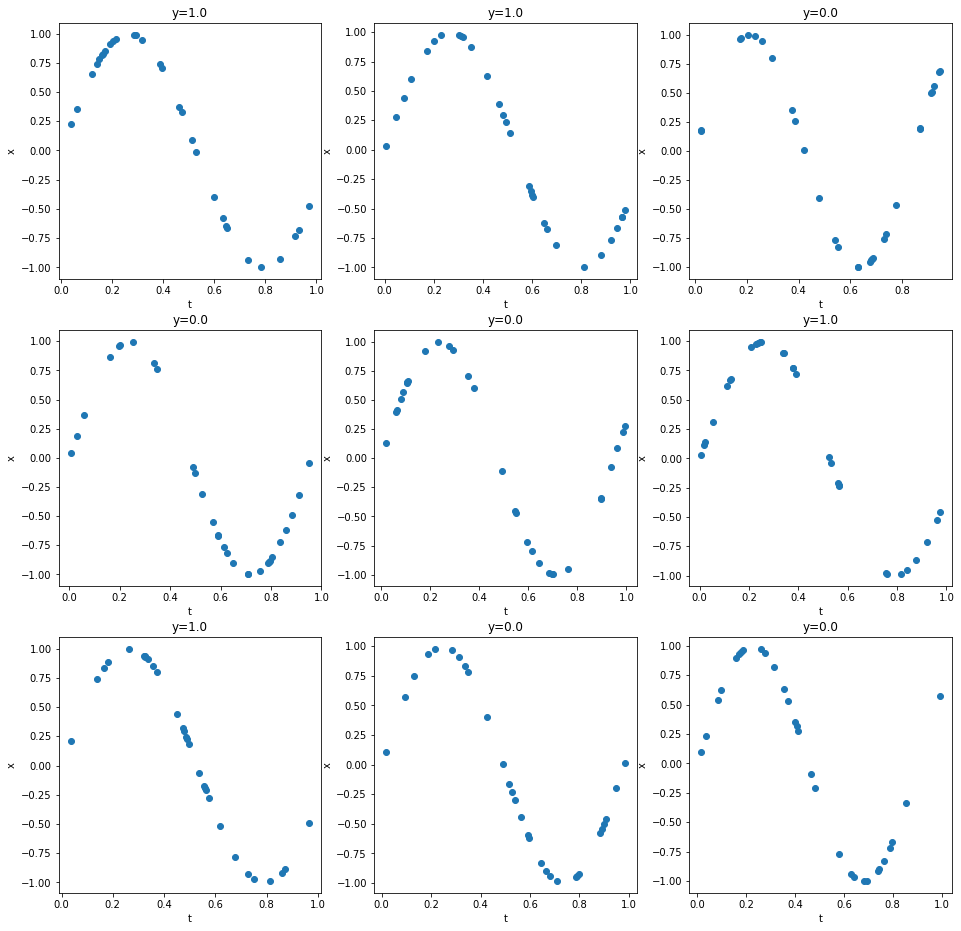

In [5]:
# example plots
n_plot = 3
fig, ax = plt.subplots(n_plot,n_plot,figsize=(16,16))
k = 0
for i in range(n_plot):
    for j in range(n_plot):
        ax[i,j].scatter(t[k],X[k])
        ax[i,j].set_title('y={}'.format(y[k].item()))
        ax[i,j].set_xlabel('t')
        ax[i,j].set_ylabel('x')
        k += 1
plt.show()

## Using an ODE-RNN for the task

The cell below sets up our networks.

ODERNN works as ...

In [6]:
class ODERNNModel(nn.Module):
    """
    Full network
    """

    def __init__(self,ODENet,input_size,hidden_size,output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.odernn = ODERNNCell(ODENet,input_size,hidden_size)
        self.decode = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, output_size),
            nn.Sigmoid(),
        )

    def forward(self,times,x):
        """
        Forward method for the main model

        x = (batch,timestep,features)
        times = 
        """

        J = x.size(1)
        batch_size = x.size(0)
        output = torch.zeros(batch_size,J,self.output_size)
        h = torch.zeros(batch_size,self.hidden_size)
        for j in range(0,J):
            xj = x[:,j,:]
            times_j = times[:,j,:]
            h = self.odernn(xj,h,times_j)
            output[:,j,:] = self.decode(h)
        return output[:,J-1,:]

In [7]:
x_size = 1  # number of input features
hidden_size = 4
output_size = 1

func = nn.Sequential(
            nn.Linear(1+hidden_size, 50),  # add one for time
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )
odenet = ODENetfromSequential(func,time_dependent=True,step_size=1e-2)
odernn = ODERNNModel(odenet,x_size,hidden_size,output_size)

optimizer = torch.optim.Adam(odernn.parameters())

In [8]:
# the time data needs to be (start,stop)
# the last stop time could be set as 10 
# but we'll just drop the final X for simplicity
nt = t.shape[1]
time_gaps = torch.cat((t[:,0:(nt-1)].unsqueeze(2),t[:,1:].unsqueeze(2)),2)
print(time_gaps.shape)
X = X[:,0:(nt-1)]

train_dataset = torch.utils.data.TensorDataset(X.unsqueeze(2),y,time_gaps)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)

X_test,y_test,t_test = get_data()
t_gaps_test = torch.cat((t_test[:,0:(nt-1)].unsqueeze(2),t_test[:,1:].unsqueeze(2)),2)
X_test = X_test[:,0:(nt-1)].unsqueeze(2)

torch.Size([256, 29, 2])


In [9]:
def train_model(model,optimizer,train_dataloader,num_epochs=10):
    for epoch in range(num_epochs):
        for batch in train_dataloader:
            x_batch,y_batch,t_batch = batch
            y_pred = model(t_batch,x_batch).squeeze(-1)
            loss = torch.nn.functional.binary_cross_entropy(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch: {}   Training loss: {}'.format(epoch, loss.item()))

In [10]:
train_model(odernn,optimizer,train_dataloader)

Epoch: 0   Training loss: 0.7076830267906189
Epoch: 1   Training loss: 0.6825861930847168
Epoch: 2   Training loss: 0.6584181785583496
Epoch: 3   Training loss: 0.6287920475006104
Epoch: 4   Training loss: 0.5904725790023804
Epoch: 5   Training loss: 0.5440387725830078
Epoch: 6   Training loss: 0.4942547082901001
Epoch: 7   Training loss: 0.4480650722980499
Epoch: 8   Training loss: 0.4098867177963257
Epoch: 9   Training loss: 0.379505455493927


In [11]:
def test_model(model,t_test,X_test,y_test):
    with torch.no_grad():
        y_pred = model(t_test,X_test).squeeze(-1)
    y_pred_binary = (y_pred > 0.5).to(y_test.dtype)
    prediction_matches = (y_pred_binary == y_test).to(y_test.dtype)
    proportion_correct = prediction_matches.sum() / y_test.size(0)
    print('Test Accuracy: {}'.format(proportion_correct))
    print('Positive class: {}'.format(torch.sum(y_test)/y_test.shape[0]))

In [12]:
test_model(odernn,t_gaps_test,X_test,y_test)

Test Accuracy: 0.8828125
Positive class: 0.578125


## How useful is the neural ODE?

A mini-ablation study

Above we do, here we do....

In [13]:
class RNNModel(nn.Module):
    """
    RNN network
    """

    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.rnn = nn.RNNCell(input_size,hidden_size)
        self.decode = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, output_size),
            nn.Sigmoid(),
        )

    def forward(self,times,x):
        """
        Forward method for the main model

        x = (batch,timestep,features)
        times = 
        """

        J = x.size(1)
        batch_size = x.size(0)
        output = torch.zeros(batch_size,J,self.output_size)
        h = torch.zeros(batch_size,self.hidden_size)
        for j in range(0,J):
            xj = x[:,j,:]
            h = self.rnn(xj,h)
            output[:,j,:] = self.decode(h)
        return output[:,J-1,:]

In [20]:
rnn = RNNModel(x_size,hidden_size,output_size)
optimizer = torch.optim.Adam(rnn.parameters())
train_model(rnn,optimizer,train_dataloader)

Epoch: 0   Training loss: 0.7006833553314209
Epoch: 1   Training loss: 0.6692261695861816
Epoch: 2   Training loss: 0.625813364982605
Epoch: 3   Training loss: 0.5794667601585388
Epoch: 4   Training loss: 0.5378656387329102
Epoch: 5   Training loss: 0.5001347064971924
Epoch: 6   Training loss: 0.46576932072639465
Epoch: 7   Training loss: 0.43816864490509033
Epoch: 8   Training loss: 0.41733500361442566
Epoch: 9   Training loss: 0.40200433135032654


In [21]:
test_model(rnn,t_gaps_test,X_test,y_test)

Test Accuracy: 0.8359375
Positive class: 0.578125


## Using an ODE-LSTM for the task

Train with an LSTM

In [16]:
class ODELSTMModel(nn.Module):
    """
    Full network
    """

    def __init__(self,ODENet,input_size,hidden_size,output_size):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.odernn = ODELSTMCell(ODENet,input_size,hidden_size)
        self.decode = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, output_size),
            nn.Sigmoid(),
        )

    def forward(self,times,x):
        """
        Forward method for the main model

        x = (batch,timestep,features)
        times = 
        """

        J = x.size(1)
        batch_size = x.size(0)
        output = torch.zeros(batch_size,J,self.output_size)
        h = torch.zeros(batch_size,self.hidden_size)
        c = torch.zeros(batch_size,self.hidden_size)
        for j in range(0,J):
            xj = x[:,j,:]
            times_j = times[:,j,:]
            h,c = self.odernn(xj,(h,c),times_j)
            output[:,j,:] = self.decode(h)
        return output[:,J-1,:]

In [17]:
# keep hidden size the same as the ODERNN model
func = nn.Sequential(
            nn.Linear(1+hidden_size, 50), 
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )
odenet = ODENetfromSequential(func,time_dependent=True)
odelstm = ODELSTMModel(odenet,x_size,hidden_size,output_size)

optimizer = torch.optim.Adam(odelstm.parameters())

In [18]:
train_model(odelstm,optimizer,train_dataloader)

Epoch: 0   Training loss: 0.6994820833206177
Epoch: 1   Training loss: 0.6940950751304626
Epoch: 2   Training loss: 0.6879590749740601
Epoch: 3   Training loss: 0.6797915697097778
Epoch: 4   Training loss: 0.6685336828231812
Epoch: 5   Training loss: 0.6534170508384705
Epoch: 6   Training loss: 0.6341511607170105
Epoch: 7   Training loss: 0.6110605001449585
Epoch: 8   Training loss: 0.5846632719039917
Epoch: 9   Training loss: 0.5552660822868347


In [19]:
test_model(odelstm,t_gaps_test,X_test,y_test)

Test Accuracy: 0.859375
Positive class: 0.578125
